In [2]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH

%aimport models.base
%aimport models.AEFIT5
%aimport models.CAEFIT
%aimport models.CAEFIT1



import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

In [11]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15u.npy'
if os.path.isfile(file):
    qsh.load(file)
else:
    qsh.load(ipysh.abs_builddir+'/te_db_1.npy')    
    qsh.rebalance_prel(15)
    qsh.save(ipysh.abs_builddir+'/te_db_r15u.npy')

In [12]:
qsh.shuffle()
# qsh.filter_number_set(15)
qsh.clean_up_poorcurves(5)
qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()
qsh.unbias_mean(0.5, 'te')
qsh.set_normal_positive()

print("QSH rebalanced 15 points size: ", len(qsh))

QSH rebalanced 15 points size:  47567


In [13]:
qsh.set_null(np.nan)
qsh.clip_values(0.1,0.6)
qsh.set_normal_positive()
qsh.set_null(np.nan)

## t-SNE Plot

In [ ]:
qsh.set_null(-1)
sne = Htls.tSNE()
# sne.perplexity = 50.
sne.random = 42

ds = qsh[range(0,4000)]
ds = np.concatenate([ds['prel'],ds['te']], axis=1)
# ds = np.array(list(zip(ds['prel'],ds['te'])))
sne(ds)
qsh.set_null(np.nan)

In [ ]:
from bokeh.io import show, output_notebook
output_notebook()

p = Hsne.tSNE_PlotBokeh()
p.set_model(sne)
p.set_data(qsh, 1000)
p.plot(notebook_url='http://172.17.0.2:8888')

## VAE reconstruction - beta

The dropout has been set to 0. ... otherwise it seems to not converge ( tested with 0.4 )
Moreover also beta has been set to 0. ... that corresponds to a deterministic vae

In [33]:
# %aimport models.base
#%aimport models.AEFIT2
# %aimport models.AEFIT3
# q_vae = models.AEFIT2.AEFIT2(latent_dim=2, feature_dim=30, dprate=0., scale=4, beta=0.)
# q_vae = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=30, dprate=0.1, scale=2, beta=0.000001, geometry=[20,20,10,10])
q_vae = models.AEFIT5.AEFIT5(latent_dim=2, feature_dim=30, dprate=0., scale=2, beta=0., geometry=[20,20,10,10])
# im1 = tf.keras.utils.plot_model(q_vae.inference_net, show_shapes=True, rankdir='LR')
# im2 = tf.keras.utils.plot_model(q_vae.generative_net, show_shapes=True, rankdir='LR')
# from IPython.display import display
# display(im1)
# display(im2)
# q_vae.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )
# q_vae.compile( tf.optimizers.Adam(1e-3), q_vae.compute_cross_entropy_loss )

AEFIT5 a ready:


In [34]:
p = Hplt.LSPlotBokeh()
p.set_model(q_vae)
p.set_data(qsh, counts=1000)
p.plot(notebook_url='http://172.17.0.2:8888')

/home/andrea/devel/rfx/rfx-hunch/build/conf/python/site-packages/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/andrea/devel/rfx/rfx-hunch/src/Tprofile_read/Hunch_lsplot.py:282: RuntimeWarning: invalid value encountered in true_divide
  return (data - m) / (M-m)


Loading BokehJS ...

In [35]:
ds = qsh.ds_array.map(lambda x,l: (x,x))

In [36]:
#models.base.manual_train_thread(q_vae, qsh, batch=200, epoch=6, loss_factor=1e-3)
# q_vae.train_thread(qsh, batch=200, epoch=10, learning_rate=1e-3).control_panel()
# models.base.train_thread(q_vae, qsh, batch=100, epoch=10, learning_rate=1e-3, callbacks=[]).control_panel()
def fun():
    global h
    h = q_vae.fit( ds.skip(3000).batch(100, drop_remainder=True), validation_data=ds.take(3000).batch(100), epochs=200, shuffle=False)
models.base.fn_thread(fn=fun, model=q_vae).control_panel()

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Epoch 1/200
445/445 [==============================] - 21s 47ms/step - loss: 0.0031 - val_loss: 0.0000e+00
Epoch 2/200
445/445 [==============================] - 19s 42ms/step - loss: 7.7278e-04 - val_loss: 6.6014e-04
Epoch 3/200
444/445 [============================>.] - ETA: 0s - loss: 6.2309e-04

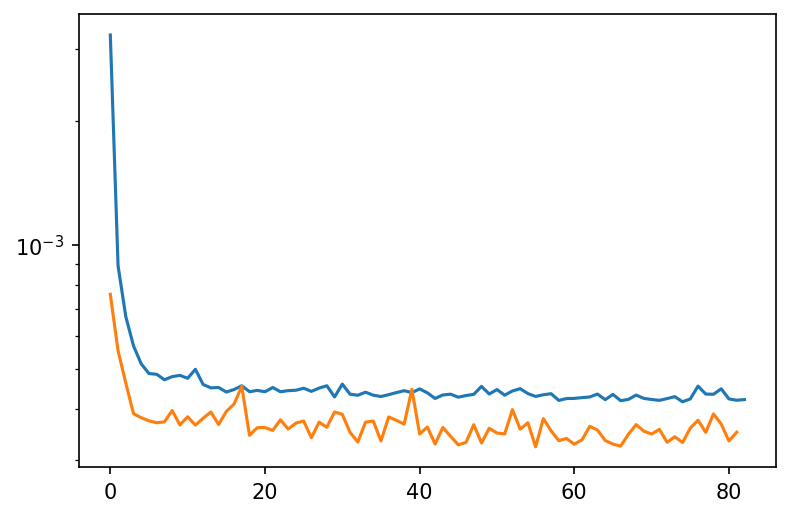

In [32]:
loss = [i[0] for i in h.history['loss']]
val_loss = [i[0] for i in h.history['val_loss']]
fig = plt.figure('loss')
fig.set_dpi(150)
plt.yscale('log')
plt.plot(loss)
plt.plot(val_loss)

In [ ]:
# q_vae.save('step7_beta0_r15_1')
q_vae.save('step7_beta0001_r15_ls2_1')

In [ ]:
q_vae.load('step7_beta0_r15_1')

In [ ]:
# extract few points curve
import copy

qsh2 = Dataset_QSH.Dataset_QSH()
qsh2.load(ipysh.abs_builddir+'/te_db_r15u.npy')
qsh2.dim = 15
qsh2.set_null(np.nan)
qsh2.set_normal_positive()
qsh2.unbias_mean(0.5, 'te')
qsh2.set_normal_positive()
qsh2.set_null(np.nan)
qsh2.clip_values(0.1,0.6)
qsh2.set_normal_positive()


qsh2.filter_number_set(5)
qsh2.dim = 15




In [ ]:
pos = 0

In [ ]:

fig = plt.figure('gen_missing_curve',figsize=(18, 6))
plt.clf()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)    
# ax1.set_xlim(-2.,2.)
ax2.set_ylim(0.,1.5)

# print(q_vae.apply_sigmoid)
print(pos)
# qsh2.shuffle()
for xy in qsh.ds_array.skip(pos).batch(1).take(1):
    xy,_ = xy
    # print(xy)
    x,y = tf.split(xy[0],2)
    ax2.scatter(x,y,s=80)
    m,v  = q_vae.encode(xy, training=False)    
    gpt = m[0].numpy()
    # print(gpt)
    ax1.scatter(gpt[0],gpt[1])

    XY = q_vae.decode(m, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())

    ax2.scatter(X,Y,s=40)
pos += 1
